# SENTIMENT ANALYSIS AND OPINION MINING PROJECT
## PUBLIC OPINION ON NEWS

https://island.ricerca.di.unimi.it/~alfio/shared/textsent/2020-21/projects.html

The New York Times Comments dataset (https://www.kaggle.com/aashita/nyt-comments?select=CommentsApril2017.csv) contains articles published on the New York Times and the comments they received from readers. <br>
The task of the project is to analyze, using the variables *editorsSelection*, *recommendations*, and *replyCount* as targets, the rate of success of a comment. This rate of success should be intepreted as a measure of how much controversial was the commented article. On this base, the project aims at studing which topics (indicated by the features sectionName and/or newDesk) were mostly controversial. Optionally, the project could also determine if a comment opinion is against or if favor of the article.

# 1. DATA PRE-PROCESSING

In [74]:
import pandas as pd
import numpy as np
import os

In [75]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [76]:
import seaborn as sns
import matplotlib.pylab as plt
import pickle
from tqdm.auto import tqdm
import time
import itertools
import functools
import operator
import time
from collections import defaultdict
import os
#from google.colab import drive, files

from glob import glob
import os
import json
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

## DATA LOADING

Create a directory where the dataset is downloaded and remove the useless folders

In [79]:
!ls 'archive'

ArticlesApril2017.csv ArticlesMarch2017.csv CommentsFeb2018.csv
ArticlesApril2018.csv ArticlesMarch2018.csv CommentsJan2017.csv
ArticlesFeb2017.csv   ArticlesMay2017.csv   CommentsJan2018.csv
ArticlesFeb2018.csv   CommentsApril2017.csv CommentsMarch2017.csv
ArticlesJan2017.csv   CommentsApril2018.csv CommentsMarch2018.csv
ArticlesJan2018.csv   CommentsFeb2017.csv   CommentsMay2017.csv


In [80]:
datasets = !ls 'archive'
datasets = functools.reduce(operator.iconcat, [d.split() for d in datasets], [])

In [81]:
# function to load data. it creates 2 datasets, one for Comments and one for Articles, by concatenating
#all the datasets from different periods

def load_data():
    
    data = {}
    for name,file in zip(['Comments', 'Articles'], ['archive/CommentsApril2017.csv','archive/ArticlesApril2017.csv']):
        save_files = {}
        for file in (d for d in datasets if d.startswith(name)) :
          save_files[str(file)] = pd.read_csv(os.path.join('archive',file), error_bad_lines=False)
        p = pd.DataFrame(index=save_files[file].columns)

        for key,value in save_files.items():
          p = pd.concat([p,pd.DataFrame(save_files[key].dtypes)], axis='columns')

        data[name] = pd.DataFrame(columns=save_files[file].columns)
        for key,value in tqdm(save_files.items()):
          data[name] = pd.concat([data[name],save_files[key]],join='outer')
        
    return data['Comments'], data['Articles'] 

In [82]:
comments, articles = load_data()

/Users/Niki/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/Niki/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/Niki/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (14,15,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/Niki/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=

## REMOVE NAN VALUES

**1. COMMENTS TABLE**

In [83]:
comments.shape

(2176364, 34)

In [84]:
# show nan values for each column
comments.isna().sum(axis=0)

approveDate                    0
commentBody                    0
commentID                      0
commentSequence                0
commentTitle               76803
commentType                    0
createDate                     0
depth                          0
editorsSelection               0
parentID                       0
parentUserDisplayName    1596067
permID                        22
picURL                         0
recommendations                0
recommendedFlag          2176364
replyCount                     0
reportAbuseFlag          2176364
sharing                        0
status                         0
timespeople                    0
trusted                        0
updateDate                     0
userDisplayName              677
userID                         0
userLocation                 504
userTitle                2176039
userURL                  2176341
inReplyTo                      0
articleID                      0
sectionName               149613
newDesk   

The columns containing too many null values need to be dropped. They are *commentTitle*, *parentUserDisplayName*, *recommendedFlag*, *reportAbuseFlag*, *userTitle*, *userURL*. *sectionName* is kept since it will be used later on. <br>

Check for columns containing '<br\/>', which is the line break XHTML tag.

In [85]:
(comments == '<br/>').sum(axis=0)

approveDate                    0
commentBody                    1
commentID                      0
commentSequence                0
commentTitle             2099561
commentType                    0
createDate                     0
depth                          0
editorsSelection               0
parentID                       0
parentUserDisplayName          0
permID                         0
picURL                         0
recommendations                0
recommendedFlag                0
replyCount                     0
reportAbuseFlag                0
sharing                        0
status                         0
timespeople                    0
trusted                        0
updateDate                     0
userDisplayName                0
userID                         0
userLocation               16319
userTitle                      0
userURL                        0
inReplyTo                      0
articleID                      0
sectionName                    0
newDesk   

The column to be removed is *commentTitle*

In [86]:
comments = comments.drop(['commentTitle','parentUserDisplayName','recommendedFlag','reportAbuseFlag','userURL'], axis='columns')

Other columns containing null values (*permID* and *userDisplayName*) are useless, so they are removed too.

In [87]:
comments = comments.drop(['permID','userDisplayName'], axis='columns')

In [88]:
comments.columns

Index(['approveDate', 'commentBody', 'commentID', 'commentSequence',
       'commentType', 'createDate', 'depth', 'editorsSelection', 'parentID',
       'picURL', 'recommendations', 'replyCount', 'sharing', 'status',
       'timespeople', 'trusted', 'updateDate', 'userID', 'userLocation',
       'userTitle', 'inReplyTo', 'articleID', 'sectionName', 'newDesk',
       'articleWordCount', 'printPage', 'typeOfMaterial'],
      dtype='object')

The columns *userLocation*, *userTitle* and *sectionName* provide useful information. Instead of removing the corresponding observations, the nan values will be transformed into the category 'unknown' to not loose too much information 

In [89]:
comments['userLocation'][comments['userLocation'].isna()] = 'Unknown'
comments['userLocation'][comments['userLocation'] == '<br/>'] = 'Unknown'
comments['sectionName'][comments['sectionName'].isna()] = 'Unknown'
comments['userTitle'][comments['userTitle'].isna()] = 'Unknown'

<ipython-input-89-28f7298447a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['userLocation'][comments['userLocation'].isna()] = 'Unknown'
<ipython-input-89-28f7298447a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['userLocation'][comments['userLocation'] == '<br/>'] = 'Unknown'
<ipython-input-89-28f7298447a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['sectionName'][comments['sectionName'].isna

There is an empty observation for *commentBody* which is deleted

In [90]:
i = comments['commentBody'][comments['commentBody'] == '<br/>'].index
comments = comments.drop(i, axis=0)

**2. ARTICLES TABLE**

In [91]:
articles.shape

(9335, 16)

In [92]:
articles.isna().sum(axis=0)

abstract            9168
articleID              0
articleWordCount       0
byline                 0
documentType           0
headline               0
keywords               0
multimedia             0
newDesk                0
printPage              0
pubDate                0
sectionName            0
snippet                0
source                 0
typeOfMaterial         0
webURL                 0
dtype: int64

We can remove the column *abstract*, since the column is almost empty (the dataset has 9335 observations)

In [93]:
articles = articles.drop(['abstract'], axis=1)

In [94]:
(articles == '<br/>').sum(axis=0)

articleID           0
articleWordCount    0
byline              0
documentType        0
headline            0
keywords            0
multimedia          0
newDesk             0
printPage           0
pubDate             0
sectionName         0
snippet             0
source              0
typeOfMaterial      0
webURL              0
dtype: int64

## VISUAL EXPLORATION  OF TARGET VARIABLES

The target variables are
- **recommendations**: how a comment is received by the community of NYT readers'
- **editorSelection**: if a comment has been picked by an editor. It gives a clue to what NYT considers worth promoting.
- **replyCount**: number of replies to a comment 

Comments with more engagement have true *editorSelection* and a high value for *recommendations* and *replyCount*. Engagement is a proxy for controversy of a comment

In [24]:
display(comments[['editorsSelection', 'recommendations','replyCount']])

,editorsSelection,recommendations,replyCount
0,False,2.0,0.0
1,False,1.0,0.0
2,False,3.0,0.0
3,False,7.0,2.0
4,False,5.0,0.0
...,...,...,...
276384,False,2.0,0.0
276385,False,2.0,0.0
276386,False,2.0,0.0
276387,False,3.0,0.0


Visually explore the target variables

[Text(0, 0, 'False'), Text(1, 0, 'True')]

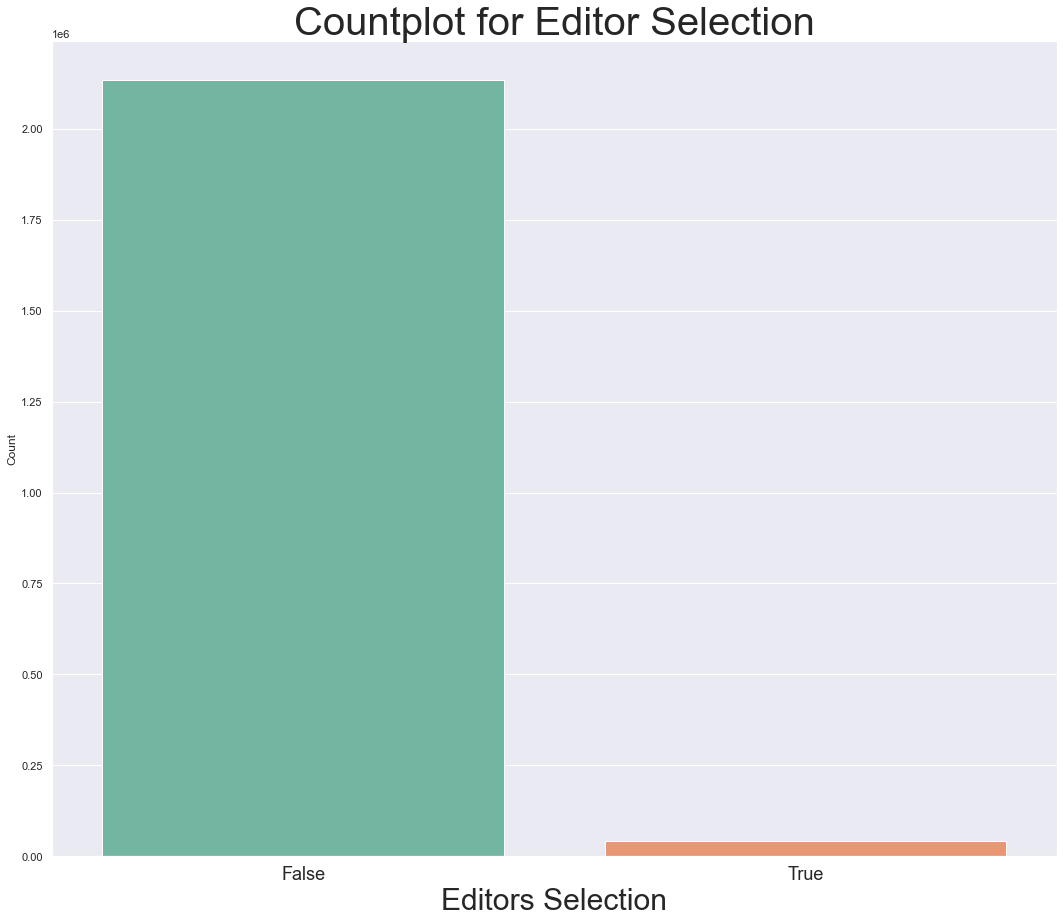

In [25]:
# BARPLOT of the editorSelection binary variable

sns.set(rc={"figure.figsize":(18,15)})
sns.set_theme(palette='Set2')
ax = sns.countplot(data=comments, x='editorsSelection')
ax.set_title("Countplot for Editor Selection",fontsize=40)
ax.set_xlabel('Editors Selection', fontsize=30)
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)

Text(0, 0.5, 'Count (logscale)')

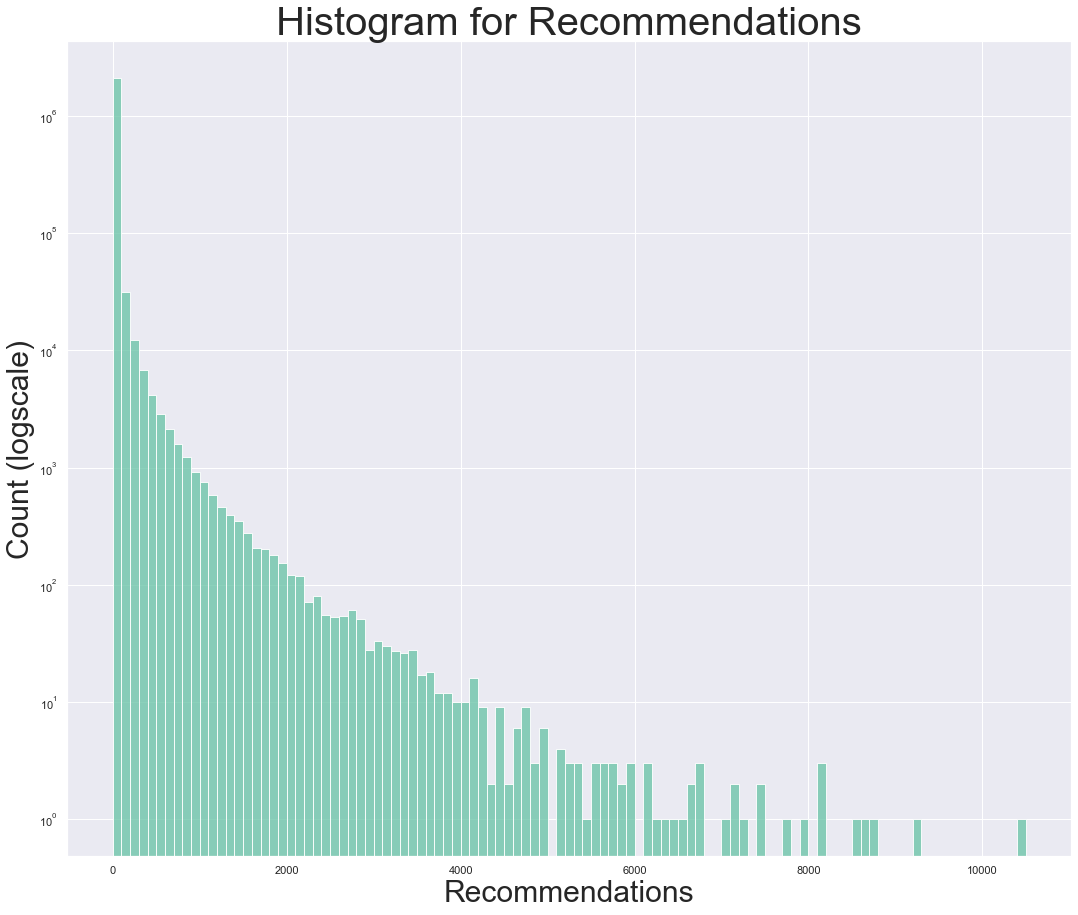

In [26]:
# HISTOGRAM of the continuous variable recommendations

sns.set(rc={"figure.figsize":(18,15)})
sns.set_theme(palette='Set2')
ax = sns.histplot(data=comments, x='recommendations', binwidth=100)
ax.set(yscale="log")
ax.set_title("Histogram for Recommendations",fontsize=40)
ax.set_xlabel('Recommendations', fontsize=30)
ax.set_ylabel('Count (logscale)', fontsize=30)

Text(0, 0.5, 'Count (logscale)')

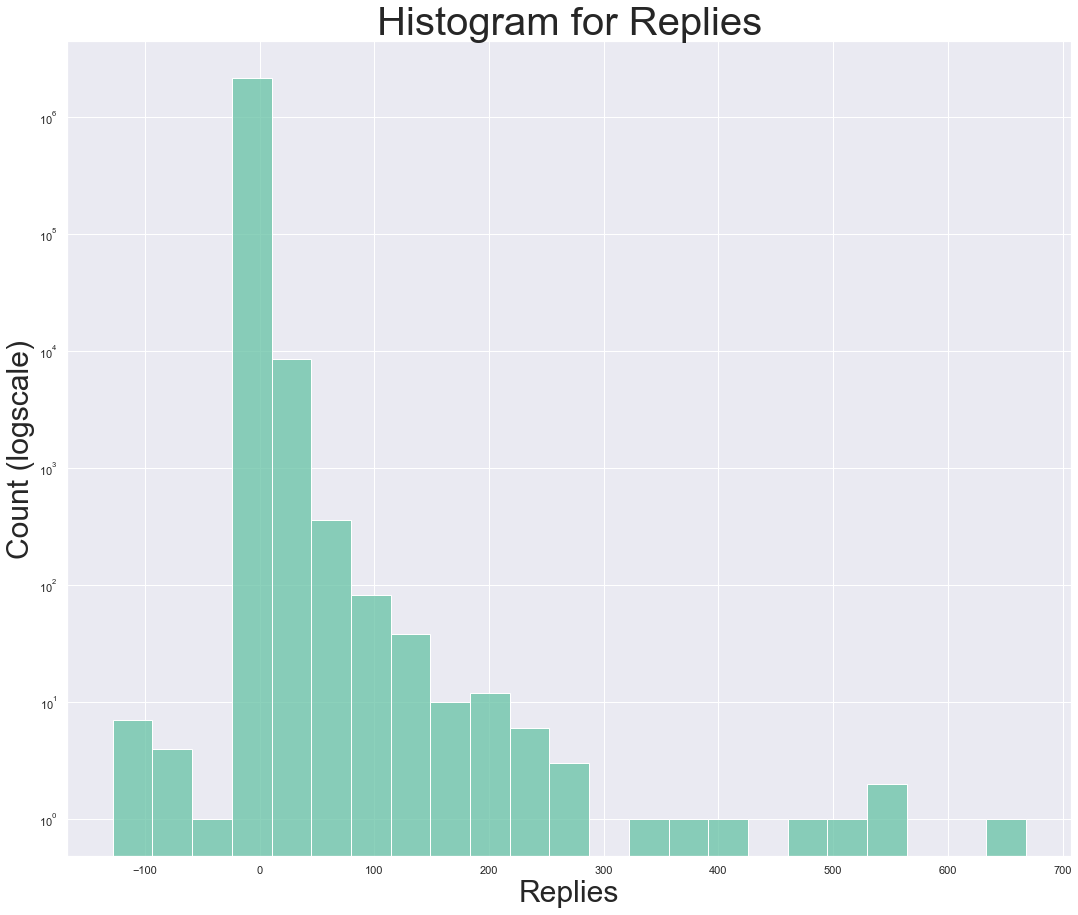

In [27]:
# HISTOGRAM of the continuous variable replyCount

sns.set(rc={"figure.figsize":(18,15)})
sns.set_theme(palette='Set2')
ax = sns.histplot(data=comments, x='replyCount')
ax.set(yscale="log")
ax.set_title("Histogram for Replies",fontsize=40)
ax.set_xlabel('Replies', fontsize=30)
ax.set_ylabel('Count (logscale)', fontsize=30)

In [95]:
# remove all the negative values since they are error

comments['replyCount'][comments['replyCount'] < 0] = 0

[None]

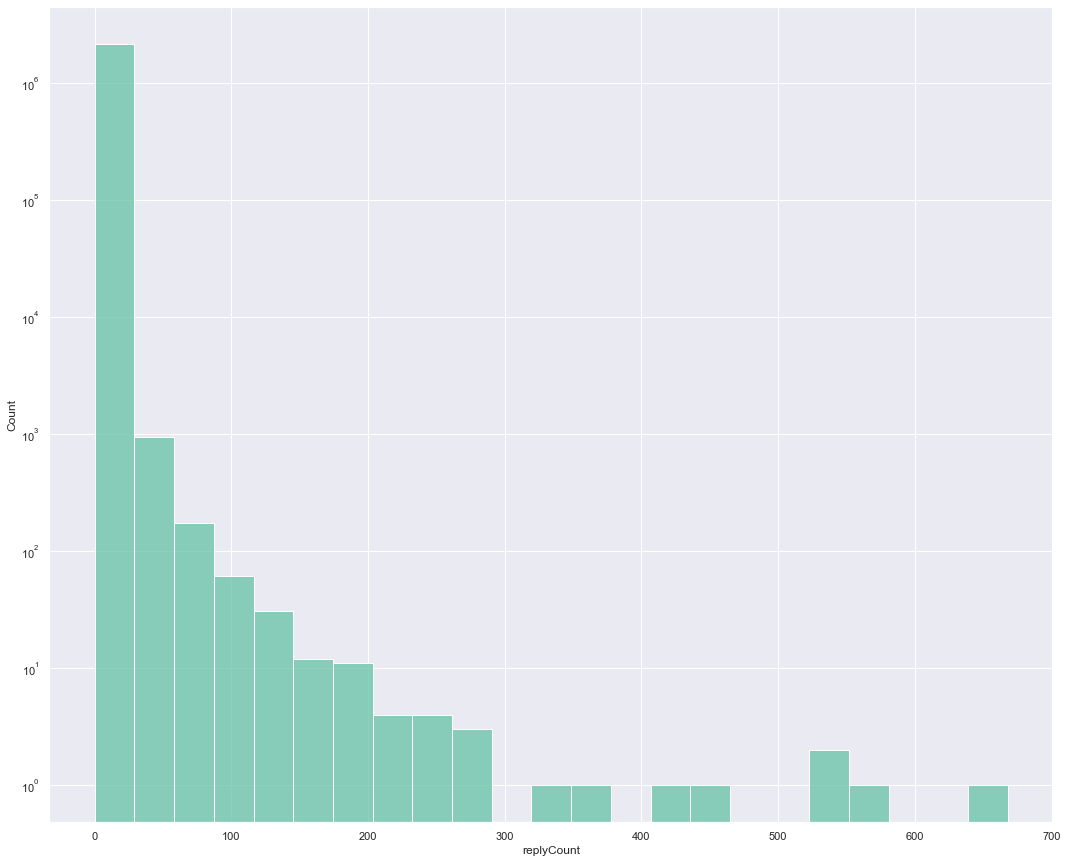

In [29]:
sns.set(rc={"figure.figsize":(18,15)})
sns.set_theme(palette='Set2')
ax = sns.histplot(data=comments, x='replyCount')
ax.set(yscale="log")

### BINARIZATION OF TARGET VARIABLES

In [96]:
# explore the distribution of recommendations

comments['recommendations'] = comments['recommendations'].astype(float)
round(comments['recommendations'].describe(),3)

count    2176355.000
mean          19.737
std          105.211
min            0.000
25%            1.000
50%            4.000
75%           10.000
max        10472.000
Name: recommendations, dtype: float64

In [97]:
# explore the distribution of replyCount

comments['replyCount'] = comments['replyCount'].astype(float)
round(comments['replyCount'].describe(),3)

count    2176355.000
mean           0.436
std            2.247
min            0.000
25%            0.000
50%            0.000
75%            0.000
max          668.000
Name: replyCount, dtype: float64

In [98]:
# explore the distribution of editorsSelection

np.unique(comments['editorsSelection'], return_counts=True)

(array([False, True], dtype=object), array([2134782,   41573]))

In [99]:
comments['recommendations_TARGET'] = 0
comments['recommendations_TARGET'][comments['recommendations']>=4] = 1

<ipython-input-99-927669186dc2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['recommendations_TARGET'][comments['recommendations']>=4] = 1


In [100]:
comments.groupby('recommendations_TARGET').count().iloc[:,0]

recommendations_TARGET
0    1076677
1    1099678
Name: approveDate, dtype: int64

In [101]:
# binarize recommendations by setting to 0 comments with no reply and to 1 comments with at least 1 reply

comments['replyCount_TARGET'] = 0
comments['replyCount_TARGET'][comments['replyCount']>=1] = 1

<ipython-input-101-70f337057347>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['replyCount_TARGET'][comments['replyCount']>=1] = 1


In [102]:
comments.groupby('replyCount_TARGET').count().iloc[:,0]

replyCount_TARGET
0    1789347
1     387008
Name: approveDate, dtype: int64

In [103]:
# binarize editorsSelection by setting to 1 True values and to 0 False values

comments['editorsSelection_TARGET'] = 0
comments['editorsSelection_TARGET'][comments['editorsSelection']==1] = 1

<ipython-input-103-618b32a22386>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['editorsSelection_TARGET'][comments['editorsSelection']==1] = 1


In [104]:
comments.groupby('editorsSelection_TARGET').count().iloc[:,0]

editorsSelection_TARGET
0    2134782
1      41573
Name: approveDate, dtype: int64

In [105]:
comments = comments.drop(['recommendations','replyCount','editorsSelection'], axis='columns')

Plot some pie charts to see the proportion between labels and see if there is some unbalance

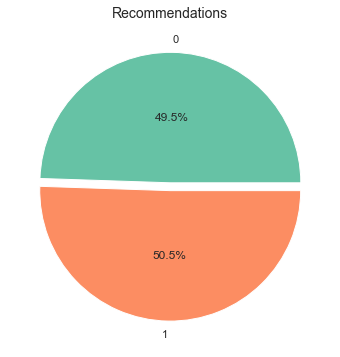

In [40]:
# PIE CHART for classes of recommendations

pie, ax = plt.subplots(figsize=[10,6])
x = comments.groupby('recommendations_TARGET').count().iloc[:,0]
labels = ['0','1']
plt.pie(x=x, autopct="%.1f%%", explode=[0.03]*2,  labels=labels, pctdistance=0.5)
plt.title("Recommendations", fontsize=14);

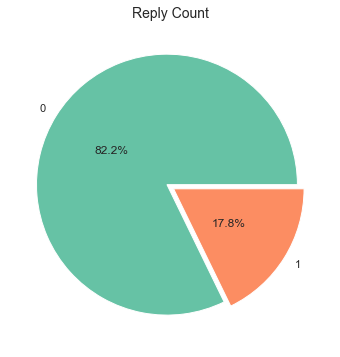

In [41]:
# PIE CHART for classes of replyCount

pie, ax = plt.subplots(figsize=[10,6])
x = comments.groupby('replyCount_TARGET').count().iloc[:,0]
labels = ['0','1']
plt.pie(x=x, autopct="%.1f%%", explode=[0.03]*2,  labels=labels, pctdistance=0.5)
plt.title("Reply Count", fontsize=14);

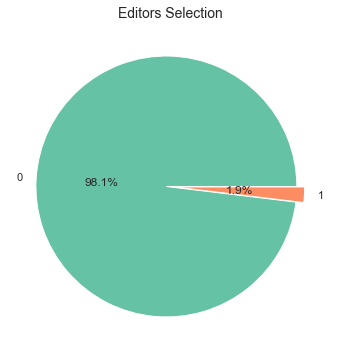

In [42]:
# PIE CHART for classes of editorsSelection

pie, ax = plt.subplots(figsize=[10,6])
x = comments.groupby('editorsSelection_TARGET').count().iloc[:,0]
labels = ['0','1']
plt.pie(x=x, autopct="%.1f%%", explode=[0.03]*2,  labels=labels, pctdistance=0.5)
plt.title("Editors Selection", fontsize=14);

Recommendations is perfectly balanced, while Reply count is somewhat unbalanced with a proportion of 1 to 4. On the other hand, Editor selection is pathologically unbalanced with a proportion of 1 to 49.

---

## FEATURE SELECTION
It is performed manually by eliminating non-informative or redundant columns

In [106]:
# concatenate the datasets

dataset = pd.merge(comments, articles, how='inner', on='articleID')

In [44]:
pd.set_option('display.max_columns', 100)
dataset.head(5)

,approveDate,commentBody,commentID,commentSequence,commentType,createDate,depth,parentID,picURL,sharing,status,timespeople,trusted,updateDate,userID,userLocation,userTitle,inReplyTo,articleID,sectionName_x,newDesk_x,articleWordCount_x,printPage_x,typeOfMaterial_x,recommendations_TARGET,replyCount_TARGET,editorsSelection_TARGET,articleWordCount_y,byline,documentType,headline,keywords,multimedia,newDesk_y,printPage_y,pubDate,sectionName_y,snippet,source,typeOfMaterial_y,webURL
0,1491245186,This project makes me happy to be a 30+ year T...,22022598.0,22022598,comment,1.491237e+09,1,0.0,https://graphics8.nytimes.com/images/apps/time...,0,approved,1.0,0.0,1491245186,46006296,"Riverside, CA",Unknown,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News,0,0,0,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
1,1491188619,Stunning photos and reportage. Infuriating tha...,22017350.0,22017350,comment,1.491180e+09,1,0.0,https://graphics8.nytimes.com/images/apps/time...,0,approved,1.0,0.0,1491188619,29202761,Unknown,Unknown,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News,0,0,0,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
2,1491188617,Brilliant work from conception to execution. I...,22017334.0,22017334,comment,1.491179e+09,1,0.0,https://graphics8.nytimes.com/images/apps/time...,0,approved,1.0,0.0,1491188617,63944806,Raleigh NC,Unknown,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News,0,0,0,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
3,1491167820,NYT reporters should provide a contributor's l...,22015913.0,22015913,comment,1.491150e+09,1,0.0,https://graphics8.nytimes.com/images/apps/time...,0,approved,1.0,0.0,1491167820,1266184,"Missouri, USA",Unknown,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News,1,1,0,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
4,1491167815,Could only have been done in print. Stunning.,22015466.0,22015466,comment,1.491147e+09,1,0.0,http://profile.ak.fbcdn.net/hprofile-ak-snc4/h...,0,approved,1.0,0.0,1491167815,61121360,"Tucson, Arizona",Unknown,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News,1,0,0,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...


In [45]:
dataset.shape

(2171172, 41)

In [46]:
# check for missing values

dataset.isna().sum(axis=0)

approveDate                0
commentBody                0
commentID                  0
commentSequence            0
commentType                0
createDate                 0
depth                      0
parentID                   0
picURL                     0
sharing                    0
status                     0
timespeople                0
trusted                    0
updateDate                 0
userID                     0
userLocation               0
userTitle                  0
inReplyTo                  0
articleID                  0
sectionName_x              0
newDesk_x                  0
articleWordCount_x         0
printPage_x                0
typeOfMaterial_x           0
recommendations_TARGET     0
replyCount_TARGET          0
editorsSelection_TARGET    0
articleWordCount_y         0
byline                     0
documentType               0
headline                   0
keywords                   0
multimedia                 0
newDesk_y                  0
printPage_y   

In [47]:
dataset.columns

Index(['approveDate', 'commentBody', 'commentID', 'commentSequence',
       'commentType', 'createDate', 'depth', 'parentID', 'picURL', 'sharing',
       'status', 'timespeople', 'trusted', 'updateDate', 'userID',
       'userLocation', 'userTitle', 'inReplyTo', 'articleID', 'sectionName_x',
       'newDesk_x', 'articleWordCount_x', 'printPage_x', 'typeOfMaterial_x',
       'recommendations_TARGET', 'replyCount_TARGET',
       'editorsSelection_TARGET', 'articleWordCount_y', 'byline',
       'documentType', 'headline', 'keywords', 'multimedia', 'newDesk_y',
       'printPage_y', 'pubDate', 'sectionName_y', 'snippet', 'source',
       'typeOfMaterial_y', 'webURL'],
      dtype='object')

Columns to be eliminated
- commentID
- commentSequence: its meaning is not clear
- commentType: ['comment', 'reporterReply', 'userReply']
- parentID
- permID
- status: it contains only the value 'approved', so it is not informative
- userDisplayName: not very informative and it contains too many values
- userID
- inReplyTo: no since the same information is already provided *commentType*
- printPage_x, printPage_y: its meaning is not clear
- headline: it is discarded. Instead, the keywords are used for articles
- multimedia: its meaning is not clear
- snippet: it is discarded. Instead, the keywords are used for articles
- webURL

Check if the columns that have been doubled when merging the dataset have the same values or not. If yes, one of the 2 can be arbitrarily deleted

In [48]:
zipped_duplicates = zip(['newDesk_x','sectionName_x','articleWordCount_x','printPage_x','typeOfMaterial_x']
               ,['newDesk_y','sectionName_y','articleWordCount_y','printPage_y','typeOfMaterial_y'])

def check_duplicates(zipped_duplicates):
  for i,j in zipped_duplicates:
    print(i,j, ': are they equal?', all(dataset[i] == dataset[j]), '\n')

In [49]:
check_duplicates(zipped_duplicates)

newDesk_x newDesk_y : are they equal? True 

sectionName_x sectionName_y : are they equal? True 

articleWordCount_x articleWordCount_y : are they equal? False 

printPage_x printPage_y : are they equal? False 

typeOfMaterial_x typeOfMaterial_y : are they equal? True 



In [50]:
dataset = dataset.drop(['newDesk_y', 'sectionName_y', 'typeOfMaterial_y'], axis=1)

Check the difference between the other two pairs of columns

In [51]:
for i,j in zip(['articleWordCount_x','printPage_x']
               ,['articleWordCount_y','printPage_y']):
  display(dataset.loc[:, (i,j) ][dataset[i] != dataset[j]])

,articleWordCount_x,articleWordCount_y
269024,601.0,656
269025,601.0,656
269026,601.0,656
269027,601.0,656
269028,601.0,656
...,...,...
320857,1246.0,1414
320858,1246.0,1414
320859,1246.0,1414
320860,1246.0,1414


,printPage_x,printPage_y
268957,9.0,0
268958,9.0,0
268959,9.0,0
268960,9.0,0
268961,9.0,0
...,...,...
340705,4.0,0
340706,4.0,0
340707,4.0,0
342661,3.0,0


Check the distributions of *articleWordCount_x* and *articleWordCount_y* to see if they have similar value as it seems by looking at the dataset.

In [52]:
display( round(dataset['articleWordCount_x'].astype(float).describe(),3) )
display( round(dataset['articleWordCount_y'].astype(float).describe(),3) )

count    2171172.000
mean        1262.012
std          870.120
min           11.000
25%          834.000
50%         1118.000
75%         1429.000
max        16336.000
Name: articleWordCount_x, dtype: float64

count    2171172.000
mean        1261.559
std          870.132
min           11.000
25%          833.000
50%         1118.000
75%         1429.000
max        16336.000
Name: articleWordCount_y, dtype: float64

The values of *printPage* indicates the page on which the article is found and it starts from 1, so value 0 indicates some error or missing value. Check which is the column with more 0 and then eliminate it

In [54]:
dataset.loc[:,('printPage_x','printPage_y')][(dataset['printPage_y']==0) & (dataset['printPage_y'] != dataset['printPage_x'])]

,printPage_x,printPage_y
268957,9.0,0
268958,9.0,0
268959,9.0,0
268960,9.0,0
268961,9.0,0
...,...,...
340705,4.0,0
340706,4.0,0
340707,4.0,0
342661,3.0,0


In [55]:
dataset.loc[:,('printPage_x','printPage_y')][(dataset['printPage_x']==0) & (dataset['printPage_x'] != dataset['printPage_y'])]

,printPage_x,printPage_y
273615,0.0,1
287377,0.0,18
287378,0.0,18
306630,0.0,4
306631,0.0,4


The distribution of values of *articleWordCount* is similar, so we can arbitrarily keep only of the two. As for *printPage*, *printPage_x* is chosen since *printPage_y* contains many 0 (5 vs 2661).

In [56]:
dataset = dataset.drop(['articleWordCount_y', 'printPage_y'], axis=1)

In [57]:
# fix the data type and set the value 0 to 'Unknown'

dataset['printPage_x'] = dataset['printPage_x'].astype('int').astype('str')
dataset['printPage_x'][dataset['printPage_x']== '0'] = 'Unknown'

<ipython-input-57-a8e315a6e717>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['printPage_x'][dataset['printPage_x']== '0'] = 'Unknown'


Columns to be eliminated
- commentID: it is not useful for predicting the target, however it is kept since it will be used later on.
- commentSequence: its meaning is not clear
- commentType: ['comment', 'reporterReply', 'userReply']
- parentID
- status: it contains only the value 'approved', so it is not informative
- userID
- inReplyTo: no since the same information is already provided *commentType*
- headline: it is discarded. Instead, the keywords are used for articles
- multimedia: its meaning is not clear
- snippet: it is discarded. Instead, the keywords are used for articles
- webURL

All the non-informative columns are removed: commentID, commentSequence (no info about it), parentID, status, inReplyTo, articleID, headline, multimedia (no info), snippet, webURL.

In [59]:
dataset = dataset.drop(['commentSequence', 'parentID','status', 'userID', 'inReplyTo', 'articleID', 'headline', 'multimedia', 'snippet', 'webURL'], axis=1)

In [60]:
dataset.columns

Index(['approveDate', 'commentBody', 'commentID', 'commentType', 'createDate',
       'depth', 'picURL', 'sharing', 'timespeople', 'trusted', 'updateDate',
       'userLocation', 'userTitle', 'sectionName_x', 'newDesk_x',
       'articleWordCount_x', 'printPage_x', 'typeOfMaterial_x',
       'recommendations_TARGET', 'replyCount_TARGET',
       'editorsSelection_TARGET', 'byline', 'documentType', 'keywords',
       'pubDate', 'source'],
      dtype='object')

In [61]:
dataset.shape

(2171172, 26)

## DERIVATION OF NEW FEATURES
### 1. picURL

We modify the column picURL and set to 0 users whose image is the default one, with value 'https://graphics8.nytimes.com/images/apps/timespeople/none.png' and to 1 users who have a personalised image

In [62]:
dataset['picURL'][dataset['picURL'] =='https://graphics8.nytimes.com/images/apps/timespeople/none.png'] = 0
dataset['picURL'][dataset['picURL'] != 0 ] = 1

<ipython-input-62-fe029dc5b523>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['picURL'][dataset['picURL'] =='https://graphics8.nytimes.com/images/apps/timespeople/none.png'] = 0
<ipython-input-62-fe029dc5b523>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['picURL'][dataset['picURL'] != 0 ] = 1


### 2. byline

In order to reduce the number of classes, only the first writer is taken

In [ ]:
import re
def func(x):
  if re.search(r"and|,", x):
    x = re.split(r',|and', x)
    x = x[0]
    x = [i for i in x.split() if i.isupper()]
    x = " ".join(x)
    return x
  else:
    x = [i for i in x.split() if i.isupper()]
    x = " ".join(x)
    return x


dataset['byline'] = dataset['byline'].apply(func)

In [ ]:
dataset.groupby('byline').count().iloc[:,0]

byline
                        375
A. J. GOLDMANN           11
A. O. SCOTT            1081
A. ODYSSEUS PATRICK     751
A.O. SCOTT              736
                       ... 
ZAHID SARDAR             10
ZEYNEP TUFEKCI         1038
ZIAD RESLAN              41
ZOE GREENBERG           175
ÉDOUARD LOUIS             1
Name: approveDate, Length: 2119, dtype: int64

### 3. pubDate
The date of publication is transformed into a float number. The value retrieved is the difference between the current time and the date of publication expressed in minutes

In [ ]:
from datetime import datetime

dataset['pubDate'] = pd.to_datetime(dataset['pubDate'], format='%Y-%m-%d %H:%M:%S')
dataset['pubDate'] = (datetime.now() - dataset['pubDate']).apply(lambda x: x.total_seconds() / 3600)

## FIX DATA TYPES 

In [66]:
dataset = dataset.astype({
    'commentID': 'int64',
    'approveDate': 'float64',
    'createDate': 'float64',
    'depth': 'object',
    'picURL': 'object',
    'sharing': 'object',
    'timespeople': 'object',
    'trusted':'object',
    'updateDate': 'float64',
    'articleWordCount_x' : 'float64',
    'recommendations_TARGET' :'object',
    'replyCount_TARGET': 'object',
    'editorsSelection_TARGET' : 'object',
    'printPage_x' : 'object',
    'byline' : 'object'
                })

In [67]:
dataset.dtypes

approveDate                float64
commentBody                 object
commentID                    int64
commentType                 object
createDate                 float64
depth                       object
picURL                      object
sharing                     object
timespeople                 object
trusted                     object
updateDate                 float64
userLocation                object
userTitle                   object
sectionName_x               object
newDesk_x                   object
articleWordCount_x         float64
printPage_x                 object
typeOfMaterial_x            object
recommendations_TARGET      object
replyCount_TARGET           object
editorsSelection_TARGET     object
byline                      object
documentType                object
keywords                    object
pubDate                     object
source                      object
dtype: object

---
# TEXT PREPROCESSING

Process the *commentBody* and *keywords* variables, which respectively contain the text of comments and the keywords of articles.

In [ ]:
pd.DataFrame(dataset['commentBody'])

,commentBody
0,The snake-filled heads comment made me think o...
1,She-devil reporting for duty!
2,XX is the new mark of the devil.
3,"""Courtland Sykes"" should be writing for The On..."
4,"I happen to descend for a few of them, because..."
...,...
2171167,C'mon Connecticut...let's add ourselves to the...
2171168,Write or call Hickenlooper's office! It was on...
2171169,"C'mon North Carolina! -- oh, who am I kidding."
2171170,"California is the federal government's #1 ""don..."


In [ ]:
# Build a function to perform tokenisation, lemmatisation and to remove html tags.

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy
from nltk.corpus import stopwords 
import string
import re


class Preprocess( BaseEstimator, TransformerMixin ):
    
    """
      
    Tokenization and Normalisation of textual data.

    Parameters
    ---------------------
    lang: language of the textual data. By default 'english'
    custom_stopwords: additional stop words to be removed from 
        the text.
    spacy_language_model: language model to be used for spacy
        lemmatizer
    custom_stopwords: additional stopwords. Default is none
    POS: part of speech to be retrieved. Default is none

    Returns
    ---------------------
    array of pre-processed text

    Attributes
    ---------------------
    stop_words_en: return the stop words to be eliminated.
    self.show_pos: return all possible part of speech tags.

    """

    def __init__(self, 
                 lang = "english",
                 spacy_language_model = "en_core_web_sm",
                 custom_stopwords = None,
                 POS = None
                 ):
        
        self.lang = lang
        self.custom_stopwords = custom_stopwords
        self.spacy_language_model = spacy_language_model
        self.stop_words_en = stopwords.words(self.lang) + list(string.punctuation) + self.custom_stopwords
        self.POS = POS
        
        self.nlp = spacy.load(self.spacy_language_model)
        self.show_pos = [(pos, spacy.explain(pos)) for pos in self.nlp.get_pipe("tagger").labels]
        
      
    def fit( self, X, y = None ):
        return self 
    

    def clean_lemmatize( self, x ):
        
        # if specific POS are given as input, only tokens corresponding to those POS are returned. the
        #text is tokenised and lemmatised
        if self.POS:
            text = [token.lemma_ for token in self.nlp(x.lower()) if token.lemma_ not in self.stop_words_en
                   and token.tag_ in self.POS]
        else:
            text = [token.lemma_ for token in self.nlp(x.lower()) if token.lemma_ not in self.stop_words_en]
        
        text = ' '.join([elem for elem in text])
        return str(text)
    
    def cleanhtml( self, x):
        
        # remove html tags
        tag = re.compile('<.*?>|br/>')
        text = re.sub(tag, '', x)
        return str(text)
    
    
    def transform( self, X, y = None ):
        
        # apply the methods
        return X.apply(self.clean_lemmatize).apply(self.cleanhtml)

In [ ]:
Preprocess().show_pos

[('$', 'symbol, currency'),
 ("''", 'closing quotation mark'),
 (',', 'punctuation mark, comma'),
 ('-LRB-', 'left round bracket'),
 ('-RRB-', 'right round bracket'),
 ('.', 'punctuation mark, sentence closer'),
 (':', 'punctuation mark, colon or ellipsis'),
 ('ADD', 'email'),
 ('AFX', 'affix'),
 ('CC', 'conjunction, coordinating'),
 ('CD', 'cardinal number'),
 ('DT', 'determiner'),
 ('EX', 'existential there'),
 ('FW', 'foreign word'),
 ('HYPH', 'punctuation mark, hyphen'),
 ('IN', 'conjunction, subordinating or preposition'),
 ('JJ', 'adjective'),
 ('JJR', 'adjective, comparative'),
 ('JJS', 'adjective, superlative'),
 ('LS', 'list item marker'),
 ('MD', 'verb, modal auxiliary'),
 ('NFP', 'superfluous punctuation'),
 ('NN', 'noun, singular or mass'),
 ('NNP', 'noun, proper singular'),
 ('NNPS', 'noun, proper plural'),
 ('NNS', 'noun, plural'),
 ('PDT', 'predeterminer'),
 ('POS', 'possessive ending'),
 ('PRP', 'pronoun, personal'),
 ('PRP$', 'pronoun, possessive'),
 ('RB', 'adverb'),


Preprocess the *commentBody* and *keywords* features. Return only nouns (singular, proper singular, proper plural), adjectives (base, comparative, superlative), personal pronouns, verbs (base form, modal auxiliary), adverbs (base, comparative, superlative, particle)

In [ ]:
POS = ['NN', 'JJ','JJR','JJS', 'MD', 'PRP', 'VB','NNP','NNPS','RB','RBR','RBS','RP']

In [ ]:
dataset['commentBody'] = Preprocess(POS=POS).transform(dataset['commentBody'])
dataset['commentBody']

0          snake comment I think medusa br/><br/>i retrog...
1                                       devil reporting duty
2                                             new mark devil
3                                     courtland onion office
4          I descend nasty roam isabella margaret eleanor...
                                 ...                        
2171167                      c'm connecticut let 's add list
2171168    write call hickenlooper office first I yesterd...
2171169                                 c'm north carolina I
2171170    california federal government donor state year...
2171171                                           stop earth
Name: commentBody, Length: 2171172, dtype: object

In [ ]:
dataset['keywords'] = Preprocess(POS=POS).transform(dataset['keywords'])
dataset['keywords']

0          united government metoo movement sexual harass...
1          united government metoo movement sexual harass...
2          united government metoo movement sexual harass...
3          united government metoo movement sexual harass...
4          united government metoo movement sexual harass...
                                 ...                        
2171167    united convention climate change global warmin...
2171168    united convention climate change global warmin...
2171169    united convention climate change global warmin...
2171170    united convention climate change global warmin...
2171171    united convention climate change global warmin...
Name: keywords, Length: 2171172, dtype: object

In [72]:
dataset.to_csv('dataset_cleansed_version.csv')